## Langgraph Agent Router

Importing required Libraries


In [1]:
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
from langgraph.graph import StateGraph,START,END

In [2]:
load_dotenv()

True

In [3]:
from langchain.tools import tool
from langgraph.store.memory import InMemoryStore
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.prebuilt.tool_node import ToolNode,tools_condition

In [4]:
from langchain.tools import tool

@tool
def add(a: int, b: int) -> int:
    """
    Add two integers.

    Parameters
    ----------
    a : int
        First number.
    b : int
        Second number.

    Returns
    -------
    int
        The sum of a and b.
    """
    return a + b


@tool
def subtract(a: int, b: int) -> int:
    """
    Subtract two integers.

    Parameters
    ----------
    a : int
        First number.
    b : int
        Second number.

    Returns
    -------
    int
        The result of a - b.
    """
    return a - b


@tool
def multiply(a: int, b: int) -> int:
    """
    Multiply two integers.

    Parameters
    ----------
    a : int
        First number.
    b : int
        Second number.

    Returns
    -------
    int
        The product of a and b.
    """
    return a * b


In [5]:
tools=[add,multiply,subtract]

In [6]:
llm=ChatGoogleGenerativeAI(
    model="gemini-2.5-flash"
)

In [8]:
llm_with_tools=llm.bind_tools(tools)

Creating the Message State

In [10]:
from typing import Annotated, TypedDict
from langchain.messages import AnyMessage
from langgraph.graph import add_messages

class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

Creating the Assistant Node

In [12]:
from langchain.messages import SystemMessage, HumanMessage,AIMessage

system_message=SystemMessage("You are a helpful assistant")

In [46]:
def assistant(state: State) -> State:
    messages = [system_message]
    messages.extend(state["messages"])
    response: AIMessage = llm_with_tools.invoke(messages)

    return {
        "messages": [response]
    }


Creating the Workflow

In [47]:
from IPython.display import Image, display

# Graph
builder = StateGraph(State)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()


Display the Graph

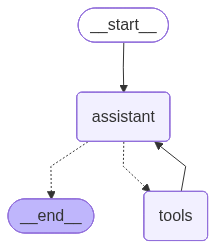

In [48]:
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
messages = [HumanMessage(content="Add 3 and 4. Multiply the output by 2. subtract the output by 5")]
messages = react_graph.invoke({"messages": messages})

{'messages': [HumanMessage(content='Add 3 and 4. Multiply the output by 2. subtract the output by 5', additional_kwargs={}, response_metadata={}, id='3e767d81-c0c0-4d08-ab85-c1b2bf06dcd6'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'add', 'arguments': '{"a": 3, "b": 4}'}, '__gemini_function_call_thought_signatures__': {'e18547fa-d656-41f2-a3e7-f847aa242722': 'Cs8CAdHtim92RhovRHMmCOTkBmOAVvKY6oiLjFWKBX0OBC8dkLkM+VPeLSvjtJ/IeCvwEzPo8RIFEABSPSrdepXG3Dwd8KzCym0aUeM4DFQbGXPXDYaLCH/YQ/uvvzXG778hPdmBGkqDxoTx5i6Z4VXd3ofTTL3VR09q/1ig41Gb9QsZQF5hqb3w3jyBreLFPDQUMboSnzYJRpcPWzHRme1w6edIHEyFF8tspdiqaUYl+UcFa5aM5WekxH2SuW6l8Cn7J00wLT3mTzDjkrHRlt6Fhl25hZRJdyQlKD/deUNgfjfPBiq9o0U+tz3pfcZFq3aMU0yDvpGzd3k6vo+4uM5+HyXBrbv4rsjc5EE86+v47tCbkSFAYHnBwgqLd4xQO8Hvqi1gZeqEgYBXaOm3LXg8cxV97x/GTmalZnZZaDI8oO0mq4wDuvjWDNX6sn+CdbY='}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_rating

In [52]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4. Multiply the output by 2. subtract the output by 5
================================== Ai Message ==================================
Tool Calls:
  add (e18547fa-d656-41f2-a3e7-f847aa242722)
 Call ID: e18547fa-d656-41f2-a3e7-f847aa242722
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================
Tool Calls:
  multiply (fd59adbd-aa2f-4edf-8986-6a638c0c3ed6)
 Call ID: fd59adbd-aa2f-4edf-8986-6a638c0c3ed6
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================
Tool Calls:
  subtract (27a6adba-c4ad-429c-8cb1-6f0e96896487)
 Call ID: 27a6adba-c4ad-429c-8cb1-6f0e96896487
  Args:
    a: 14
    b: 5
================

### Creating the Checkpointer 

Compiling the graph with checkpointer

In [53]:
agent = builder.compile(checkpointer=InMemorySaver())


Creating the Thread with unique thread ID

In [59]:
from langchain_core.runnables import RunnableConfig

config:RunnableConfig={"configurable":{
    "thread_id":"1"
}}

In [61]:
messages = [HumanMessage("Add 3 and 4")]

responses = agent.invoke({"messages":messages},config)
for m in responses['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4
================================== Ai Message ==================================
Tool Calls:
  add (e6c81fe5-3fb6-47a7-8e41-6eb7062d282f)
 Call ID: e6c81fe5-3fb6-47a7-8e41-6eb7062d282f
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.
================================ Human Message =================================

Add 3 and 4
================================== Ai Message ==================================
Tool Calls:
  add (b2100461-c038-42af-b705-67d0684ff11c)
 Call ID: b2100461-c038-42af-b705-67d0684ff11c
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 

WE have the same thread Id it will use the messages from the memory

In [62]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = agent.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4
================================== Ai Message ==================================
Tool Calls:
  add (e6c81fe5-3fb6-47a7-8e41-6eb7062d282f)
 Call ID: e6c81fe5-3fb6-47a7-8e41-6eb7062d282f
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.
================================ Human Message =================================

Add 3 and 4
================================== Ai Message ==================================
Tool Calls:
  add (b2100461-c038-42af-b705-67d0684ff11c)
 Call ID: b2100461-c038-42af-b705-67d0684ff11c
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 